<a name='1'></a>
## 1 - Packages

As usual, begin by loading in the packages.

In [3]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow_datasets as tfds
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
data_dir = '../input/chinese-calligraphy-styles-by-calligraphers/data/data'

In [5]:
builder = tfds.ImageFolder(data_dir)
print(builder.info)

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_path='/root/tensorflow_datasets/image_folder/1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=20),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=21007, num_shards=1>,
        'train': <SplitInfo num_examples=84022, num_shards=1>,
    },
    citation="""""",
)


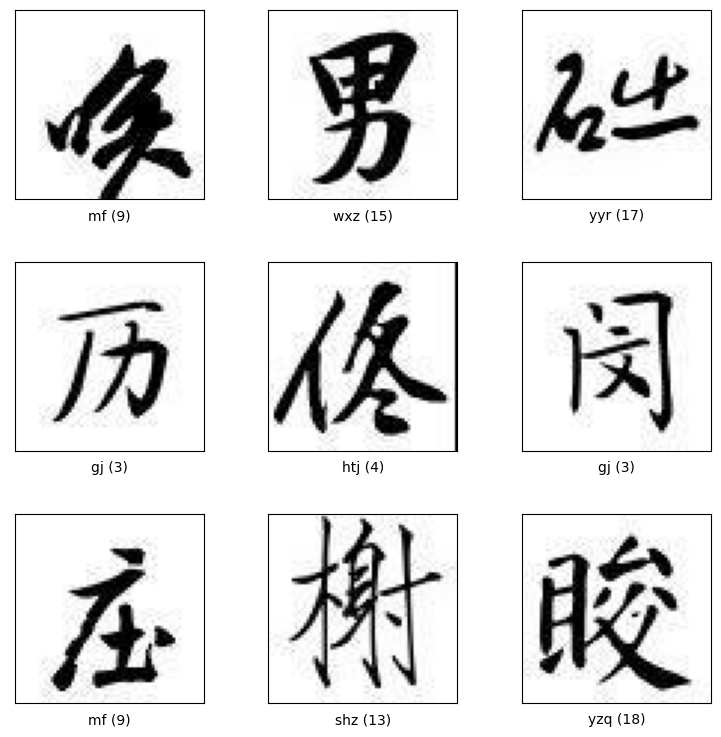

84022


In [6]:
train_ds = builder.as_dataset(split='train', shuffle_files=True, as_supervised=True)
tfds.show_examples(train_ds, builder.info)
num_examples = builder.info.splits['train'].num_examples
print(num_examples)

In [7]:
test_ds = builder.as_dataset(split='test', shuffle_files=True, as_supervised=True)
num_test_examples = builder.info.splits['test'].num_examples
print(num_test_examples)

21007


In [8]:
def preprocess():
    def preprocess_func(img, y):
        img = tf.image.convert_image_dtype(img, dtype=tf.float32)
        return img, y

    return preprocess_func

train_ds = train_ds.map(preprocess(), num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(preprocess(), num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [9]:
train_ds, valid_ds = tf.keras.utils.split_dataset(train_ds, left_size=0.9)

print(int(train_ds.cardinality()))
print(int(valid_ds.cardinality()))

75620
8402


In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 64, 3)
()


In [11]:
for images, labels in valid_ds:
  print(images.shape)
  print(labels.shape)
  break

(64, 64, 3)
()


In [12]:
label_names = builder.info.features['label'].names
print(label_names)

['bdsr', 'csl', 'fwq', 'gj', 'htj', 'hy', 'lgq', 'lqs', 'lx', 'mf', 'mzd', 'oyx', 'sgt', 'shz', 'smh', 'wxz', 'wzm', 'yyr', 'yzq', 'zmf']


In [13]:
batch_size = 128
train_ds, valid_ds, test_ds = [ds.batch(batch_size, drop_remainder=False) for ds in [train_ds, valid_ds, test_ds]]

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 64, 64, 3)
(128,)


In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(64, 64, 3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(20)
])

In [20]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)      

In [22]:
history = model.fit(
  train_ds,
  validation_data = valid_ds,
  epochs = 10
)

Epoch 1/10
591/591 [==============================] - 530s 895ms/step - loss: 2.3584 - accuracy: 0.2395 - val_loss: 1.0653 - val_accuracy: 0.6573
Epoch 2/10
591/591 [==============================] - 531s 898ms/step - loss: 0.8086 - accuracy: 0.7381 - val_loss: 0.6705 - val_accuracy: 0.7873
Epoch 3/10
591/591 [==============================] - 533s 901ms/step - loss: 0.5738 - accuracy: 0.8143 - val_loss: 0.4986 - val_accuracy: 0.8361
Epoch 4/10
591/591 [==============================] - 522s 883ms/step - loss: 0.4488 - accuracy: 0.8547 - val_loss: 0.4253 - val_accuracy: 0.8613
Epoch 5/10
591/591 [==============================] - 533s 902ms/step - loss: 0.3667 - accuracy: 0.8818 - val_loss: 0.3805 - val_accuracy: 0.8751
Epoch 6/10
591/591 [==============================] - 538s 910ms/step - loss: 0.3072 - accuracy: 0.9004 - val_loss: 0.3497 - val_accuracy: 0.8828
Epoch 7/10
591/591 [==============================] - 531s 899ms/step - loss: 0.2599 - accuracy: 0.9155 - val_loss: 0.3327 -

In [23]:
history.history

{'loss': [2.3583836555480957,
  0.8086300492286682,
  0.5737800598144531,
  0.44876909255981445,
  0.3667442798614502,
  0.30724677443504333,
  0.2598532736301422,
  0.22422350943088531,
  0.1926637589931488,
  0.16589048504829407],
 'accuracy': [0.23946045339107513,
  0.7381116151809692,
  0.8142819404602051,
  0.8547474145889282,
  0.8818302154541016,
  0.900383472442627,
  0.9154588580131531,
  0.9264612793922424,
  0.9369478821754456,
  0.9461782574653625],
 'val_loss': [1.0653119087219238,
  0.6705464720726013,
  0.49855148792266846,
  0.4252721071243286,
  0.3804813027381897,
  0.34971657395362854,
  0.33268609642982483,
  0.3231971263885498,
  0.29051852226257324,
  0.28803014755249023],
 'val_accuracy': [0.6573435068130493,
  0.7873125672340393,
  0.8361104726791382,
  0.8613425493240356,
  0.8751487731933594,
  0.8827660083770752,
  0.8926445841789246,
  0.8944299221038818,
  0.9062128067016602,
  0.9100214242935181]}

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


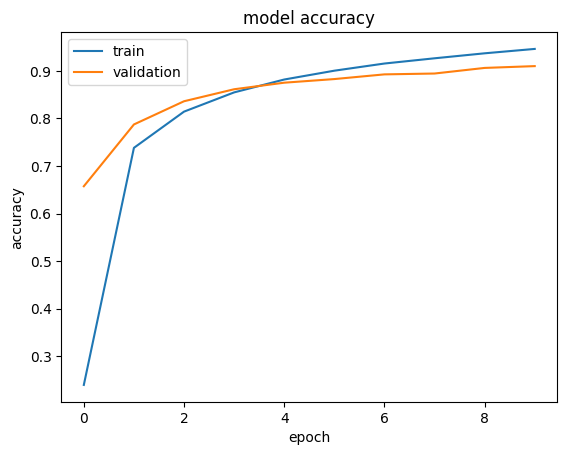

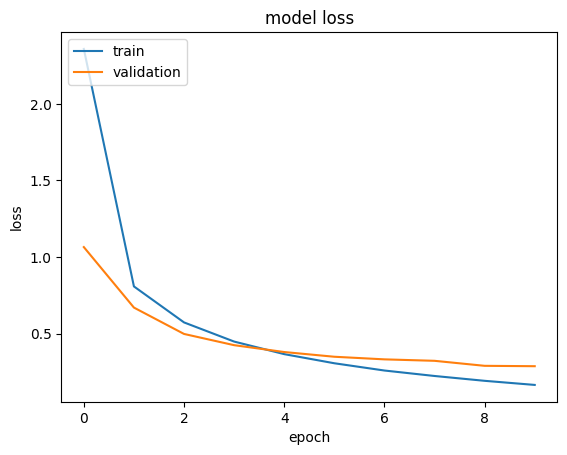

In [25]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [28]:
test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE)

print(int(test_ds.cardinality()))

165


In [29]:
evaluation = model.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

165/165 [==============================] - 43s 258ms/step - loss: 0.2847 - accuracy: 0.9100

loss: 0.2847
accuracy: 0.9100
